In [24]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [25]:
import random

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

In [27]:
# 15번째 sample까지만 print
for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[1.00903453 0.36948632] 2
[1.01456163 0.14529675] 2
[-0.08165741  0.01663839] 0
[-0.09025599  0.27784173] 0
[0.08802856 1.32856834] 3
[ 0.01012923 -0.21371223] 0
[1.13731032 0.04931267] 2
[1.04441804 0.03915829] 2
[-0.24112249  1.02769508] 3
[1.01376412 0.70186466] 1
[ 0.21984732 -0.03386645] 0
[-0.15192467  0.0471371 ] 0
[-0.18554261  0.80193151] 3
[1.01305706 0.9551489 ] 1
[ 1.22168411 -0.07774053] 2
[ 0.71218432 -0.00397708] 2


In [28]:
# label 0, 1 -> 0으로 매핑
# label 2, 3 -> 1로 매핑

def label_map(y_, from_, to_):
    y = np.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

In [22]:
y_train.max(), y_train.min()

(tensor(1.), tensor(0.))

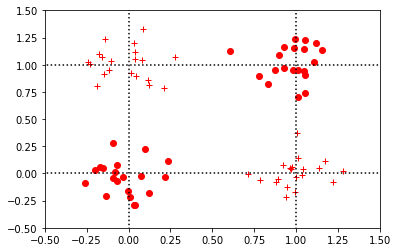

In [29]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')

plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [30]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
print(y_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])
(80,)


In [33]:
y_test.shape

torch.Size([20])

# Model

In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__() # NeuralNet(자식 클래스)이 상속받는 torch.nn.Module(부모 클래스)을 우리의 NeuralNet에 불러오겠다는 의미
            self.input_size = input_size      # init 시 self.를 앞에 붙여줘야 함.
            self.hidden_size  = hidden_size
            
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            ### 수정 ###
            # self.linear_2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            ############
            self.linear_last = torch.nn.Linear(self.hidden_size, 1)   # Binary Classification(classes: 2)
            self.sigmoid = torch.nn.Sigmoid()                         # 0~1
            
        def forward(self, input_tensor):
            x = self.linear_1(input_tensor)
            x = self.relu(x)
            x = self.linear_last(x)
            output = self.sigmoid(x)
            return output

In [34]:
learning_rate = 0.01
epochs = 2000
hidden_size = 5

### Model Initialize ###
model = NeuralNet(2, hidden_size)   # (Input size, Hidden size)

criterion = torch.nn.BCELoss()  # Binary Cross-Entropy  
# torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # Stochastic Gradient Descent

In [36]:
# print(model)

In [37]:
model.eval() # Gradient Backpropagation(역전파)를 중지 -> Validation 및 Test 시에 사용

test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.69706791639328


In [42]:
print(model(x_test).shape)
print(model(x_test).squeeze().shape)

torch.Size([20, 1])
torch.Size([20])


In [11]:
# 한 번 학습(1 epoch)
model.train()   # Gradient Update 실행.
optimizer.zero_grad()   # Gradient를 0으로 초기화
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward() # Backpropagation
optimizer.step()

In [43]:
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        train_losses.append(train_loss.item())
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.6960739493370056
Train loss at 100 is 0.6898325681686401
Train loss at 200 is 0.6836288571357727
Train loss at 300 is 0.6769230365753174
Train loss at 400 is 0.6688065528869629
Train loss at 500 is 0.6593352556228638
Train loss at 600 is 0.6483110189437866
Train loss at 700 is 0.6367390155792236
Train loss at 800 is 0.6248918771743774
Train loss at 900 is 0.6134195327758789
Train loss at 1000 is 0.6015506982803345
Train loss at 1100 is 0.5888550877571106
Train loss at 1200 is 0.5752359628677368
Train loss at 1300 is 0.560672402381897
Train loss at 1400 is 0.5451957583427429
Train loss at 1500 is 0.5290042161941528
Train loss at 1600 is 0.5120700597763062
Train loss at 1700 is 0.4945358633995056
Train loss at 1800 is 0.476754367351532
Train loss at 1900 is 0.45869892835617065


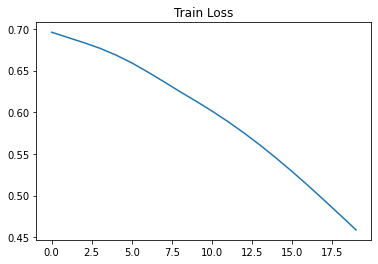

In [51]:
# train loss 그래프

plt.plot(train_losses)
plt.title('Train Loss')
plt.show()

In [44]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.42589497566223145


In [45]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 0.5425,  0.5859],
        [-1.0859,  1.0592],
        [-0.1540,  0.1458],
        [-0.1942,  0.4085],
        [ 1.1196, -1.0776]])), ('linear_1.bias', tensor([ 0.6351, -0.0523,  0.5188,  0.2581, -0.0226])), ('linear_last.weight', tensor([[-0.1743,  1.3985, -0.0351, -0.1209,  1.2863]])), ('linear_last.bias', tensor([-0.4147]))])


In [46]:
# 새로운 모델에 학습된 가중치 로드

new_model = NeuralNet(2, hidden_size)

new_model.load_state_dict(torch.load('./model.pt'))

new_model.eval()
print('벡터 [0, 1]이 레이블 1을 가질 확률은 {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]이 레이블 1을 가질 확률은 0.6629934310913086


In [47]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [49]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1.])
tensor(100.)


In [50]:
# Train epoch마다 성능 평가

for i in range(0,2000,100):
    new_model = NeuralNet(2, hidden_size)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(50.)
======epoch : 200 =======
tensor(40.)
======epoch : 300 =======
tensor(65.)
======epoch : 400 =======
tensor(95.)
======epoch : 500 =======
tensor(100.)
======epoch : 600 =======
tensor(100.)
======epoch : 700 =======
tensor(100.)
======epoch : 800 =======
tensor(100.)
======epoch : 900 =======
tensor(100.)
======epoch : 1000 =======
tensor(100.)
======epoch : 1100 =======
tensor(100.)
======epoch : 1200 =======
tensor(100.)
======epoch : 1300 =======
tensor(100.)
======epoch : 1400 =======
tensor(100.)
======epoch : 1500 =======
tensor(100.)
======epoch : 1600 =======
tensor(100.)
======epoch : 1700 =======
tensor(100.)
======epoch : 1800 =======
tensor(100.)
======epoch : 1900 =======
tensor(100.)
